In [1]:
from process_bigraph import Composite
from process_bigraph.composite import ProcessTypes

from cdFBA import register_types
from cdFBA.processes.dfba import DFBA, UpdateEnvironment, Chemostat, Injector, WaveFunction


from cdFBA.utils import DFBAconfig, model_from_file, get_objective_reaction, get_injector_spec, get_wave_spec, \
    get_chemo_spec, dfba_config, get_initial_counts
from cdFBA.utils import dfba_config_from_model, get_single_dfba_spec, dfba_config, environment_spec, initial_environment

from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
# name1 = "Escherichia coli K12"
# model_file_1 = "iAF1260"
# medium_type='exchange'
# model_1 = model_from_file(model_file=model_file_1)
# media_1 = DFBAconfig(model=model_1, medium_type=medium_type)
# initial_counts = get_initial_counts(model=model_1, biomass=0.1, medium_type=medium_type, name=name1)
# initial_env = initial_environment(volume=1.0, initial_counts= initial_counts)
# initial_dfba_update = {
#     name1: {
#         key: 0 for key in initial_counts.keys()
#     }
# }
# config_1 = dfba_config(
#     model_file = model_file_1,
#     name = name1,
#     kinetics = media_1.kinetics,
#     reaction_map = media_1.reaction_map,
#     biomass_identifier = media_1.biomass_indentifier,
#     bounds = None,
# )

In [3]:
# spec = {name1: get_single_dfba_spec(config=config_1, interval=0.5)}
# spec['shared environment'] = initial_env
# spec['dFBA Results'] = initial_dfba_update
# spec['update environment'] = environment_spec()

In [4]:
#Provide names for the two dFBA processes.
name1 = "E.coli"
name2 = "S.flexneri"

# define a single dFBA model
spec = {
    name1: get_single_dfba_spec(model_file= "iAF1260", name=name1)
}

#introduce second model
spec[name2] = get_single_dfba_spec(model_file = "iSFxv_1172", name=name2)

#initiate initial shared environment
spec['shared environment'] = initial_environment(volume=2, species_list=[name1, name2])

#initiate initial dFBA results - 0 for all metabolites and biomass
spec['dFBA Results'] = {name1:
    {
        "glucose": 0,
        "acetate": 0,
        spec[name1]['config']['name']: 0,
    },
    name2:
    {
        "glucose": 0,
        "acetate": 0,
        spec[name2]['config']['name']: 0,
    }
}

#introduce the UpdateEnvironment step
spec['update environment'] = environment_spec()

pprint(spec)

{'E.coli': {'_type': 'process',
            'address': 'local:DFBA',
            'config': {'biomass_identifier': 'BIOMASS_Ec_iAF1260_core_59p81M',
                       'bounds': {'ATPM': {'lower': 1, 'upper': 1},
                                  'EX_o2_e': {'lower': -2, 'upper': None}},
                       'interval': 0.1,
                       'kinetics': {'acetate': (0.5, 7), 'glucose': (0.02, 15)},
                       'model_file': 'iAF1260',
                       'name': 'E.coli',
                       'reaction_map': {'acetate': 'EX_ac_e',
                                        'glucose': 'EX_glc__D_e'}},
            'inputs': {'current_update': ['dFBA Results'],
                       'shared_environment': ['shared environment']},
            'interval': 1.0,
            'outputs': {'dfba_update': ['dFBA Results', 'E.coli']}},
 'S.flexneri': {'_type': 'process',
                'address': 'local:DFBA',
                'config': {'biomass_identifier': 'BIOMASS_Ec_iJO

In [5]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('DFBA', DFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('Chemostat', Chemostat)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [6]:
#create simulation composite
sim = Composite({
        "state": spec,
        "emitter": {'mode': 'all'}},
        core=core
    )

In [7]:
#run simulation
sim.run(20)

/opt/anaconda3/envs/fbapractice/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [8]:
#gather results
results = sim.gather_results()[('emitter',)]

In [9]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
    dfba_spec = timepoint.pop(name1)
    print(f'TIME: {time}')
    pprint(f'STATE: {timepoint}')
    env = [timepoint['shared environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

TIME: 0.0
("STATE: {'S.flexneri': {'inputs': {'shared_environment': ['shared "
 "environment'], 'current_update': ['dFBA Results']}, 'outputs': "
 "{'dfba_update': ['dFBA Results', 'S.flexneri']}, 'interval': 1.0, 'address': "
 "'local:DFBA', 'config': {'model_file': 'iSFxv_1172', 'name': 'S.flexneri', "
 "'kinetics': {'glucose': (0.02, 15), 'acetate': (0.5, 7)}, 'reaction_map': "
 "{'glucose': 'EX_glc__D_e', 'acetate': 'EX_ac_e'}, 'biomass_identifier': "
 "'BIOMASS_Ec_iJO1366_core_53p95M', 'bounds': {'EX_o2_e': {'lower': -2.0, "
 "'upper': None}, 'ATPM': {'lower': 1.0, 'upper': 1.0}}, 'interval': 0.1}, "
 "'instance': <cdFBA.processes.dfba.DFBA object at 0x30b33d790>}, 'shared "
 "environment': {'concentrations': {'glucose': 40.0, 'acetate': 0.0, 'E.coli': "
 "0.25, 'S.flexneri': 0.25}, 'counts': {'glucose': 80, 'acetate': 0, 'E.coli': "
 "0.5, 'S.flexneri': 0.5}, 'volume': 2}, 'dFBA Results': {'E.coli': "
 "{'glucose': 0, 'acetate': 0, 'E.coli': 0}, 'S.flexneri': {'glucose': 0, "
 "'

In [10]:
#extract time-series for the shared environment
env = [timepoint['shared environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

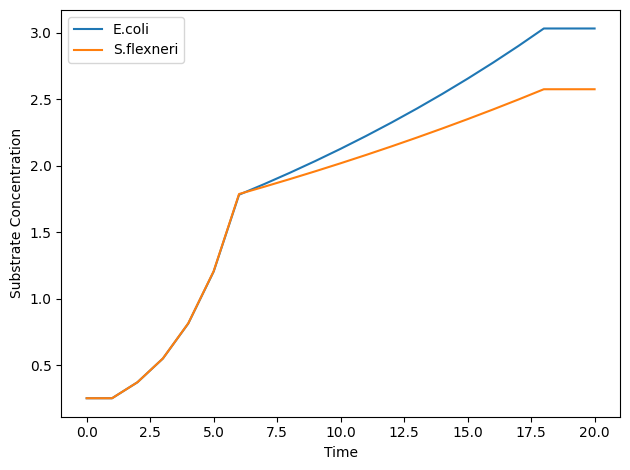

In [11]:
#plot results for biomass
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key not in ['glucose', 'acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()

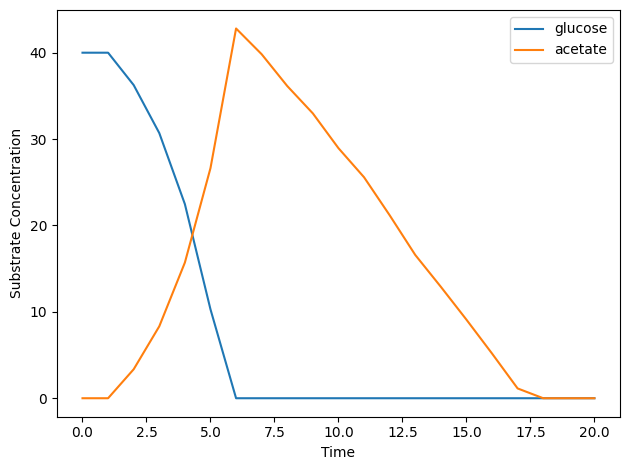

In [12]:
#plote substrates
fig, ax = plt.subplots(dpi=100)
for key, value in env_combined.items():
    if key in ['glucose', 'acetate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time')
plt.ylabel('Substrate Concentration')
plt.legend()
plt.tight_layout()
plt.show()